In [ ]:
import sys
import datetime
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Our model
from models.ClassificationModel import get_classification_model

In [ ]:
# Global variables
BATCH_SIZE = 512
NB_EPOCHS = 2
IMG_WIDTH = 96
IMG_HEIGHT = 96
TRAIN_DATA_PATH = 'dataset_3_classes/train'
TEST_DATA_PATH = 'dataset_3_classes/test'
VAL_DATA_PATH = 'dataset_3_classes/val'
CLASS_NAMES = ['NORMAL', 'BACTERIA', 'VIRUS']
# AUTOTUNE = tf.data.experimental.AUTOTUNE
VERBOSE = 1
MODEL_NAME = "vgg16"

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=tf.float32),
    tf.keras.metrics.TruePositives(name='true_positives', dtype=tf.float32),
    tf.keras.metrics.FalsePositives(name='false_positives', dtype=tf.float32),
    tf.keras.metrics.TrueNegatives(name='true_negatives', dtype=tf.float32),
    tf.keras.metrics.FalseNegatives(name='false_negatives', dtype=tf.float32),
    tf.keras.metrics.Precision(name='precision', dtype=tf.float32),
    tf.keras.metrics.Recall(name='recall', dtype=tf.float32),
    tf.keras.metrics.AUC(name='auc', dtype=tf.float32),
]



In [ ]:
def save_model_h5(model=None, model_name='vgg16'):
    """
    Save a TF Model into h5 format
    """
    model.save('saved_model/{}_vgg_16_model.h5'
               .format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
    print("Model saved successfully.")

In [ ]:
def get_callbacks():
    """
    Define the callbacks for the ML model
    """
    return [
        tf.keras.callbacks.TensorBoard(os.path.join(
            "logs\\{}".format('vgg16'), datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1)
    ]

In [ ]:
def get_label(file_path):
    """
    Get the label of a file - Can be NORMAL, VIRUS OR BACTERIE
    """
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES



In [ ]:
def get_label_predicted(predictions):
    """
    Return the label for a given prediction array
    """
    preds = list(predictions)
    return CLASS_NAMES[preds.index(max(preds))]

In [ ]:
def generate_html(history, model, results, predictions):
    """
    Function that generate an html page and open it in the browser
    - history is the history for the model train steps
    - results is the metrics results get from the train step
    - predictions is the predictive result gotten for the test datas
    """
    # Generate the graph for accuracy, loss, val_accuracy, val_loss
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs_range = range(NB_EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.yscale('log')

    # Display metrics for testing purpose
    print('Normal, Virus or Bacteria {} trained model : '.format(MODEL_NAME))
    for name, value in zip(model.metrics_names, results):
        print(f'{name} : {value}')

    # Display predictions
    for predict in predictions:
        print('Predictions : ', predict, 'Result :',
              get_label_predicted(predict))

    plt.show()



In [ ]:
def main():
    """
    Main function
    """
    # if the model already exist, load it.
    model = get_classification_model()

    # To get the nb of steps and how many images we got
    nb_normal_tr = len(os.listdir('{}/NORMAL'.format(TRAIN_DATA_PATH)))
    nb_bacteria_tr = len(os.listdir('{}/BACTERIA'.format(TRAIN_DATA_PATH)))
    nb_virus_tr = len(os.listdir('{}/VIRUS'.format(TRAIN_DATA_PATH)))
    nb_normal_val = len(os.listdir('{}/NORMAL'.format(VAL_DATA_PATH)))
    nb_bacteria_val = len(os.listdir('{}/BACTERIA'.format(VAL_DATA_PATH)))
    nb_virus_val = len(os.listdir('{}/VIRUS'.format(VAL_DATA_PATH)))
    total_train = nb_normal_tr + nb_bacteria_tr + nb_virus_tr
    total_val = nb_normal_val + nb_bacteria_val + nb_virus_val

    # Our datas generators
    train_image_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=.15,
        height_shift_range=.15,
        horizontal_flip=True,
        zoom_range=0.5
    )  # Generator for our training data
    validation_image_generator = ImageDataGenerator(
        rescale=1./255)  # Generator for our validation data
    test_image_generator = ImageDataGenerator(
        rescale=1./255)  # Generator for our validation data

    train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                               directory=TRAIN_DATA_PATH,
                                                               shuffle=True,
                                                               target_size=(
                                                                   IMG_HEIGHT, IMG_WIDTH),
                                                               class_mode='categorical'
                                                               )
    val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                                  directory=VAL_DATA_PATH,
                                                                  target_size=(
                                                                      IMG_HEIGHT, IMG_WIDTH),
                                                                  class_mode='categorical'
                                                                  )
    test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                             directory=TEST_DATA_PATH,
                                                             target_size=(
                                                                 IMG_HEIGHT, IMG_WIDTH),
                                                             class_mode='categorical'
                                                             )

    # Train the model
    history = model.fit(
        train_data_gen,
        callbacks=get_callbacks(),
        steps_per_epoch=total_train // BATCH_SIZE,
        epochs=NB_EPOCHS,
        validation_data=val_data_gen,
        validation_steps=total_val // BATCH_SIZE
    )

    model.summary()

    # Use a testing model to display metrics
    testing_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    testing_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer='adam',
        metrics=METRICS
    )

    # Evalutate the model with test datas
    results = testing_model.evaluate(test_data_gen, verbose=0)

    # Predict the test datas
    predictions = testing_model.predict(test_data_gen)

    save_model_h5(testing_model, 'classification')
    generate_html(history, testing_model, results, predictions)

Found 3513 images belonging to 3 classes.
Found 1174 images belonging to 3 classes.
Found 1169 images belonging to 3 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 2 steps
Epoch 1/2
6/6 [==============================] - 155s 26s/step - loss: 1.7641 - accuracy: 0.4055 - val_loss: 1.4027 - val_accuracy: 0.2627
Epoch 2/2
6/6 [==============================] - 202s 34s/step - loss: 1.2422 - accuracy: 0.4055 - val_loss: 1.0560 - val_accuracy: 0.4746
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 16)        0         
______________________

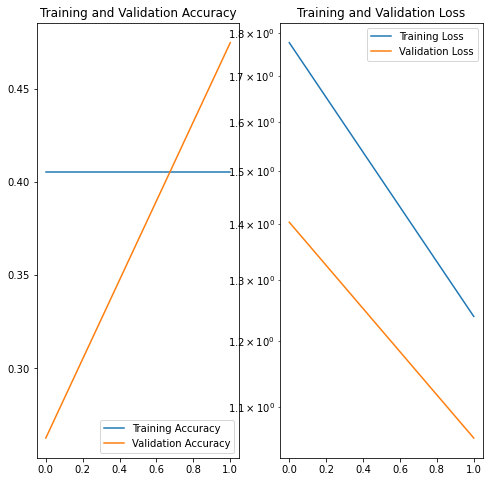

In [11]:
main()